In [1]:
import fix_project_path

import os
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
import seaborn as sns
from tqdm.notebook import tqdm

from config import basepaths
from config import Config
from datasets.loader import load_data, DataFoldFactory
from experiment import ExperimentKeys
from paths import ExperimentPaths, makedirs

%load_ext autoreload
%autoreload 2

In [2]:
data_keys = {
    #'gazebase_all_sr1000_sl1000_dxy': "GazeBase (1000 s)",
    'gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy': "GazeBase",# (5000 s)",
    #'judo_sr1000_sl1000_rxy': "JuDo1000 (right eye)",
    'judo_sr1000_sl1000_savgol_maxvel1000_bxy': "JuDo1000",# (both eyes)",
    'potec_sr1000_sl1000_savgol_maxvel1000_dxy': "PoTeC",
}

model_keys = {
    'eky2': "EKY2",
    #'del_slow': "DELslow",
    #'del_fast_zstd': "DELfast0",
    #'del_zstd': "DEL0",
    #'del_fast_vmin1': "DELfast1",
    #'del_vmin1': "DEL1",
    #'del_fast_vmin4': "DELfast",
    #'del_vmin4': "DEL",
    #'del_fast_vmin10': "DELfast10",
    #'del_vmin10': "DEL",
    #'del_fast': "DELfast40",
    #'del': "DEL40",
}

explainer_keys = {
    'deeplift_zero': 'DL',
    #'input_x_gradient': 'IxG',
    'integrated_gradients_zero': 'IG',
    #'occlusion_s3': 'Occ(3)',
    #'occlusion_s5': 'Occ(5)',

    #'lrp_epsilon0_only': 'LRP-ε0',
    'lrp_epsilon0.25_only': 'LRP',#-Ε',
    #'lrp_epsilon1e-6_only': 'LRP-ε',
    
    #'lrp_epsilon_plus': 'LRP-ε+',
    #'lrp_epsilon_plus_flat': 'LRP-ε+♭',
    
    #'lrp_epsilon_gamma0.25': 'LRP-γ',
    #'lrp_epsilon_gamma0.25_flat': 'LRP-γ♭',
    #'lrp_epsilon_gamma0.1': 'LRP-εγ.1',
    #'lrp_epsilon_gamma0.1_flat': 'LRP-εγ.1♭',

    #'lrp_epsilon_alpha2_beta1': 'LRP-α2β1',
    #'lrp_epsilon_alpha2_beta1_flat': 'LRP-α2β1♭',
    #'lrp_epsilon_alpha1_beta0': 'LRP-α1β0',
    #'lrp_epsilon_alpha1_beta0_flat': 'LRP-α1β0♭',
}

metric_keys = {
    #'area_under_curve': 'score',
    #'attribution_localisation': 'score',
    #'attribution_localisation_weighted': 'score',
    #'localized_attribution_aggregate_max': 'score',
    #'localized_attribution_aggregate_mean': 'score',
    #'localized_attribution_aggregate_median': 'score',
    #'pointing_game': 'score',
    #'pointing_game_weighted': 'score',
    #'relevance_mass_accuracy': 'score',
    #'top_1_percent_intersection': 'score',
    #'top_1_percent_intersection_concept_influence': 'score',
    'top_2_percent_intersection': 'top k intersection',
    'top_2_percent_intersection_concept_influence': 'concept influence',
    #'top_5_percent_intersection': 'score',
    #'top_5_percent_intersection_concept_influence': 'score',
    #'top_10_percent_intersection': 'score',
    #'top_10_percent_intersection_concept_influence': 'score',
    #'top_20_percent_intersection': 'score',
    #'top_20_percent_intersection_concept_influence': 'score',
}

segmentation_keys = {
    'ivt.fixation': 'fixation',
    'engbert.saccade': 'saccade',
    #'clip': 'clip',
    #'nan': 'nan',
    #'unclassified': 'unclassified',
}

In [3]:
eval_rootdir = Path('/mnt/scratch/krakowczyk/workspace/xai-timeseries/evaluations/attribution_localization/')
plot_dirpath = Path('/home/krakowczyk/workspace/xai-timeseries/plots/attribution_localizations/')

makedirs(plot_dirpath)

In [4]:
fold_indices = {}
dataset_sizes = {}

for data_key in tqdm(data_keys):
    keys = ExperimentKeys(data_key=data_key)
    config = Config(experiment_keys=keys)
    paths = ExperimentPaths(basepath=basepaths.workspace, config=config)
    data = load_data(config=config, paths=paths)
    
    fold_indices[data_key] = data['folds']
    dataset_sizes[data_key] = len(data['X'])

  0%|          | 0/3 [00:00<?, ?it/s]

Selected input channels: ['dx', 'dy']
X.shape: (67483, 5000, 2)
Y.shape: (67483, 100)
Folds: [1, 2, 3, 4]
Selected input channels: ['dxr', 'dyr', 'dxl', 'dyl']
X.shape: (172623, 1000, 4)
Y.shape: (172623, 150)
Folds: [1, 2, 3, 4]
Selected input channels: ['dx', 'dy']
X.shape: (107540, 1000, 2)
Y.shape: (107540, 75)
Folds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [5]:
dfs = []

for data_key in data_keys:
    index = pd.MultiIndex.from_product(
        iterables=[
            [data_key],
            model_keys.keys(),
            explainer_keys.keys(),
            metric_keys.keys(),
            segmentation_keys.keys(),
            range(dataset_sizes[data_key])
        ],
        names=['data', 'model', 'explainer', 'metric', 'segmentation', 'instance_id'],
    )

    df = pd.DataFrame(index=index, columns=['score', 'fold'])

    for fold_id, fold_masks in fold_indices[data_key].items():
        test_mask = fold_masks['test']
        test_idx = np.where(test_mask)[0]
        df.loc[df.index.get_level_values('instance_id').isin(test_idx)] = fold_id

    dfs.append(df)

df = pd.concat(dfs)
del dfs

df.sort_index(inplace=True)

display(df)

score  \
data                                             model explainer            metric                                       segmentation    instance_id         
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   engbert.saccade 0               1   
                                                                                                                                         1               1   
                                                                                                                                         2               1   
                                                                                                                                         3               1   
                                                                                                                                         4               1   
...                                                                                                                                                    ...   
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence ivt.fixation    107535         11   
                                                                                                                                         107536         11   
                                                                                                                                         107537         11   
                                                                                                                                         107538         11   
                                                                                                                                         107539         11   

                                                                                                                                                     fold  
data                                             model explainer            metric                                       segmentation    instance_id       
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   engbert.saccade 0              1  
                                                                                                                                         1              1  
                                                                                                                                         2              1  
                                                                                                                                         3              1  
                                                                                                                                         4              1  
...                                                                                                                                                   ...  
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence ivt.fixation    107535        11  
                                                                                                                                         107536        11  
                                                                                                                                         107537        11  
                                                                                                                                         107538        11  
                                                                                                                                         107539        11  

[4171752 rows x 2 columns]

In [6]:
for data_key in tqdm(data_keys):
    for model_key in tqdm(model_keys.keys(), leave=False):
        for explainer_key in tqdm(explainer_keys.keys(), leave=False):
            for metric_key in tqdm(metric_keys.keys(), leave=False):
                for segmentation_key in tqdm(segmentation_keys.keys(), leave=False):
                    
                    filepath = eval_rootdir / data_key / model_key / explainer_key / metric_key / segmentation_key / 'scores.npy'

                    if filepath.exists():
                        score = np.load(filepath)

                        result_idx = data_key, model_key, explainer_key, metric_key, segmentation_key
                        df.loc[result_idx, 'score'] = score
                            
                    else:
                        print(f'skip {filepath}')



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
df[df.score.isnull()]

score  \
data                                             model explainer            metric                                       segmentation    instance_id         
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   engbert.saccade 91            NaN   
                                                                                                                                         327           NaN   
                                                                                                                                         421           NaN   
                                                                                                                                         590           NaN   
                                                                                                                                         675           NaN   
...                                                                                                                                                    ...   
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence ivt.fixation    105230        NaN   
                                                                                                                                         105438        NaN   
                                                                                                                                         105448        NaN   
                                                                                                                                         106666        NaN   
                                                                                                                                         106868        NaN   

                                                                                                                                                     fold  
data                                             model explainer            metric                                       segmentation    instance_id       
gazebase_all_sr1000_sl5000_savgol_maxvel1000_dxy eky2  deeplift_zero        top_2_percent_intersection                   engbert.saccade 91             1  
                                                                                                                                         327            1  
                                                                                                                                         421            1  
                                                                                                                                         590            1  
                                                                                                                                         675            1  
...                                                                                                                                                   ...  
potec_sr1000_sl1000_savgol_maxvel1000_dxy        eky2  lrp_epsilon0.25_only top_2_percent_intersection_concept_influence ivt.fixation    105230         6  
                                                                                                                                         105438         7  
                                                                                                                                         105448         7  
                                                                                                                                         106666         5  
                                                                                                                                         106868         6  

[307560 rows x 2 columns]

In [8]:
df = df.reset_index()

df.data = df.data.map(data_keys)
df.model = df.model.map(model_keys)
df.explainer = df.explainer.map(explainer_keys)
df.segmentation = df.segmentation.map(segmentation_keys)


display(df)

,data,model,explainer,metric,segmentation,instance_id,score,fold
0,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,0,0.99,1
1,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,1,0.98,1
2,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,2,1.0,1
3,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,3,1.0,1
4,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,4,1.0,1
...,...,...,...,...,...,...,...,...
4171747,PoTeC,EKY2,LRP,top_2_percent_intersection_concept_influence,fixation,107535,0.0,11
4171748,PoTeC,EKY2,LRP,top_2_percent_intersection_concept_influence,fixation,107536,0.0,11
4171749,PoTeC,EKY2,LRP,top_2_percent_intersection_concept_influence,fixation,107537,0.0,11
4171750,PoTeC,EKY2,LRP,top_2_percent_intersection_concept_influence,fixation,107538,0.0,11


In [9]:
display(df[df.score.isnull()].head())

df = df[~df.score.isnull()]

display(df[df.score.isnull()].head())

,data,model,explainer,metric,segmentation,instance_id,score,fold
91,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,91,NaN,1
327,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,327,NaN,1
421,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,421,NaN,1
590,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,590,NaN,1
675,GazeBase,EKY2,DL,top_2_percent_intersection,saccade,675,NaN,1


,data,model,explainer,metric,segmentation,instance_id,score,fold


In [59]:
import matplotlib as mpl

def plot_scores_catplot(
    scores, figsize=(15,6),
    xlabel='', ylabel='score', xticks=None,
    savepath=None, rc_context=None, kind='bar',
    ylim=None,
    legend=True,
    col_titles="",
):
    sns.set_theme(style = "whitegrid", font_scale=1.3)
    #sns.set_style({'legend.frameon':False})
    
    if rc_context is not None:
        sns.set_context('notebook', font_scale=1.4, rc=rc_context)
    
    #fig = plt.figure(figsize=figsize)
    g = sns.catplot(
        x='segmentation',
        y='score',
        col='data',
        #row='metric',
        hue='explainer',
        data=scores,
        kind=kind,
        #ci=68,
        showfliers=False,
        sharex=False,
        sharey=True,
        palette='deep',
        legend=False,
        #legend=legend,
        #legend_out=True,
        order=['fixation', 'saccade']
    )
    
    #if legend:
    #    sns.move_legend(g, "upper right", title=None, frameon=True, bbox_to_anchor=(1.2, 0.4))

    #if show_baseline:
    #    g.map(plt.axhline, y=1/n_classes, color=".7", dashes=(2, 1), zorder=0)

    # Adjust title and axis labels directly
    #g.set_titles("{col_name}")
    g.set_titles(col_titles)
    g.set_axis_labels(x_var=xlabel, y_var=ylabel)    
    if xticks:
        g.set(xticks=xticks)
        
    for ax in g.axes.flat:
        #ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=1))
        
        #ax = g
        ax.tick_params(
            axis='x',
            which='major',
            direction='out',
            length=6,
            width=2,
            pad=0,
            color='k',
            bottom=True,
            reset=False,
        )

        ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(n=2))
        ax.set_xticklabels(ax.get_xticklabels(), 
                           rotation=45, 
                           horizontalalignment='right',
                           rotation_mode='anchor'
                          )

        #ax.set_xlabel(xlabel)
        #ax.set_ylabel(ylabel)

        ax.grid(False, which='major', axis='x')
        ax.grid(True, which='minor', axis='x')
        ax.grid(True, which='major', axis='y')
        ax.grid(False, which='minor', axis='y')
        
        ax.axhline(1, color='gray', linestyle='--')
        
        if ylim is not None:
            ax.set_ylim(ylim)

   
    #plt.legend(legend)
    #ax.get_legend().remove()    
    
    #print(xticklabels)
    #print(dir(xticklabels[0]))
    #ax.set_ylim((0.9*scores['score'].min(), 1.1*scores['score'].max()))
        
    #g.set(ylim=(0, 1))
    g.fig.set_size_inches(*figsize)
    #plt.suptitle(input_key)
    
    plt.tight_layout(pad=0.8)
    plt.tight_layout()
    
    if legend:
        plt.legend(
            ncol=3,
            loc='center', 
            bbox_to_anchor=(-0.75, -0.35),
        )
    

    plt.subplots_adjust(hspace=0.1, wspace=0.1)

    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    
    plt.show()
    plt.close()

top_2_percent_intersection
/home/krakowczyk/workspace/xai-timeseries/plots/attribution_localizations/attribution-top_2_percent_intersection.pdf


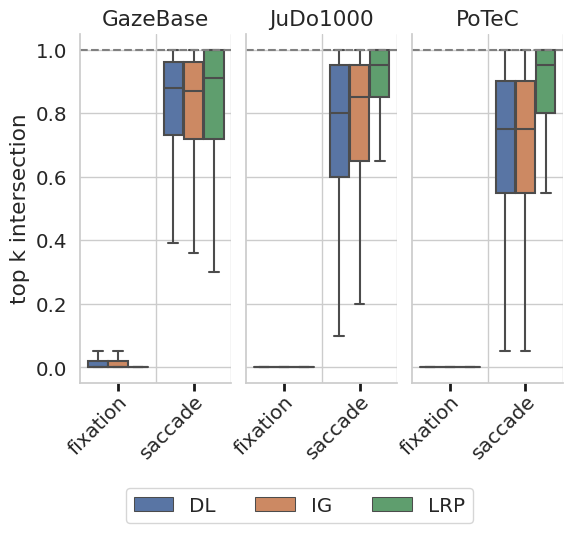

top_2_percent_intersection_concept_influence
/home/krakowczyk/workspace/xai-timeseries/plots/attribution_localizations/attribution-top_2_percent_intersection_concept_influence.pdf


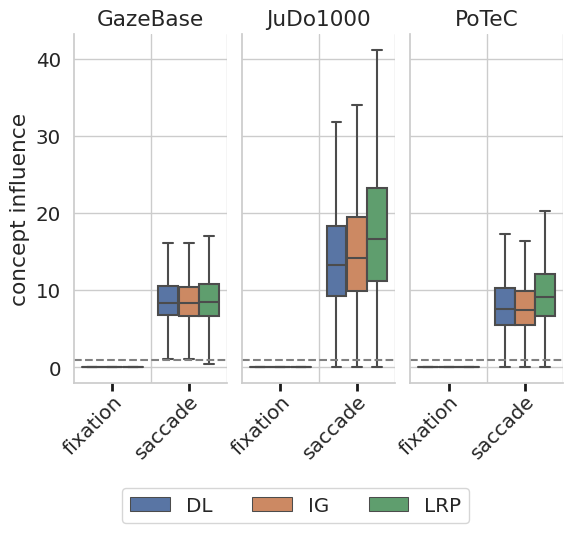

In [60]:
for metric, df_metric in df.groupby(by='metric'):
    print(metric)
    filename = f"attribution-{metric.lower().replace(' ', '-').replace('(', '').replace(')', '')}.pdf"
    savepath = plot_dirpath / filename
    print(savepath)
    plot_scores_catplot(
        df_metric.reset_index(),
        savepath=savepath,
        kind='box',
        ylabel=metric_keys[metric],
        figsize=(6, 5),
        legend=True,
        col_titles="{col_name}"
    )